In [61]:
import ROOT as r
import matplotlib.pyplot as plt
import rootpy.plotting.root2matplotlib as rplt
from rootpy.plotting import Hist, HistStack, Legend, Canvas
from rootpy.io import root_open
import rootpy
import numpy as np
import matplotlib.pylab as pylab
from sklearn import metrics
import root_numpy
from scipy.interpolate import interp1d

params = {'legend.fontsize': 'x-large', 'axes.labelsize': 'x-large', 'axes.titlesize':'x-large', 'xtick.labelsize':'x-large', 'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

# Plot simple distributions

In [91]:
def plot(f, v, PU):
    
    rootfile = r.TFile.Open(f)
    tree = rootfile.Get("tree")
    
    data = root_numpy.tree2array(tree)

    if PU != None:
        selc = ((data["nPUtrue"] >= PU[0]) & (data["nPUtrue"] < PU[1]))
    else:
        selc = np.ones(data["nPUtrue"].shape, dtype=bool)
    
    b = data[v][(data["Jet_hadronFlavour"] ==5)  & selc]
    c = data[v][(data["Jet_hadronFlavour"] ==4)  & selc]
    l = data[v][(data["Jet_hadronFlavour"] ==0)  & selc]

    print(b.shape, c.shape, l.shape)

    # normalize histograms
    weights_b = np.ones(b.shape)/float(b.shape[0])
    weights_c = np.ones(c.shape)/float(c.shape[0])
    weights_l = np.ones(l.shape)/float(l.shape[0])
    
    fig = plt.figure()
    plt.hist(b, 50, histtype="step", weights=weights_b)
    plt.hist(c, 50, histtype="step", weights=weights_c)
    plt.hist(l, 50, histtype="step", weights=weights_l)
    plt.xlabel(v)
    plt.ylabel("A.U.")

((119850,), (42566,), (203787,))


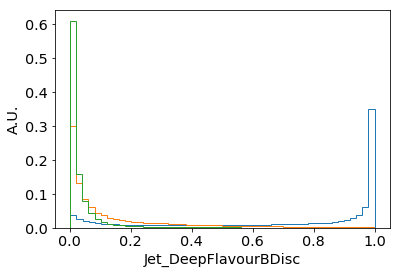

In [95]:
plot("ttbar_chs_2021.root", "Jet_DeepFlavourBDisc", None)

# Plot ROC curves

In [162]:
def roc(f, v, PU):
    
    rootfile = r.TFile.Open(f)
    tree = rootfile.Get("tree")
    
    data = root_numpy.tree2array(tree)
    
    fpr = {}
    tpr = {}

    
    if PU != None:
        selc = ((data["nPUtrue"] >= PU[0]) & (data["nPUtrue"] < PU[1]))
    else:
        selc = np.ones(data["nPUtrue"].shape, dtype=bool)

    BvsL_pred = data[v][((data["Jet_hadronFlavour"] ==5) | (data["Jet_hadronFlavour"] ==0)) & selc ]
    BvsC_pred = data[v][((data["Jet_hadronFlavour"] ==5) | (data["Jet_hadronFlavour"] ==4)) & selc ]
    BvsL_true = data["Jet_hadronFlavour"][((data["Jet_hadronFlavour"] ==5) | (data["Jet_hadronFlavour"] ==0)) & selc]
    BvsC_true = data["Jet_hadronFlavour"][((data["Jet_hadronFlavour"] ==5) | (data["Jet_hadronFlavour"] ==4)) & selc]
    
    fpr["BvsL"], tpr["BvsL"], thresholds = metrics.roc_curve(BvsL_true, BvsL_pred,pos_label=5.)
    fpr["BvsC"], tpr["BvsC"], thresholds = metrics.roc_curve(BvsC_true, BvsC_pred,pos_label=5.)
    
    for d in ["BvsL", "BvsC"]:
        f = interp1d(fpr[d], tpr[d], kind="linear")
        print(d, float(f(0.1)))

    p1 = plt.plot(tpr["BvsL"], fpr["BvsL"], label="PU: {0}".format(PU))
    p2 = plt.plot(tpr["BvsC"], fpr["BvsC"], ls="--", color=p1[0].get_color()) 


In [163]:
def plot_several_roc(filelist, v, puBinning, label):
    
    fig = plt.figure()
    plt.xlim([0.0,1.0])
    plt.ylim([0.0005, 1.0])
    plt.yscale("log")
    plt.grid(axis='both', which='both')
    plt.xlabel("b efficiency")
    plt.ylabel("mistag rate")
    plt.title(r"$\mathbf{CMS}$ private work", fontsize=16, x=0.0, ha="left", y=1.05, va="top")
    plt.text(0.99, 0.99, label, fontsize=12, ha="right", va="bottom")
    
    for f in filelist:
        for puBin in puBinning:
            roc(f, v, puBin)
    plt.legend()
    plt.show()

('BvsL', 0.912572577043323)
('BvsC', 0.763258337055233)
('BvsL', 0.9073022237071686)
('BvsC', 0.7534989048520622)
('BvsL', 0.9010235110880368)
('BvsC', 0.744003560038567)
('BvsL', 0.9023188845104577)
('BvsC', 0.7357456805092452)


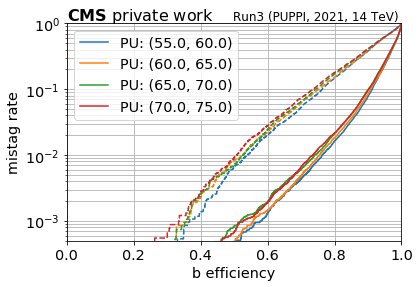

In [170]:
#roc("ttbar_chs_2021.root", "Jet_DeepFlavourBDisc", (55.,60.))
plot_several_roc(["ttbar_puppi_2021.root"], "Jet_DeepFlavourBDisc", [(55.,60.), (60.,65.), (65.,70.), (70., 75.)], label="Run3 (PUPPI, 2021, 14 TeV)")